In [10]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [11]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import shutil
import yaml
from rdkit import RDLogger
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

def read_yaml(yaml_path: str) -> MCTS:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    file_level = logging.DEBUG if conf.get("debug") else logging.INFO
    logger = make_logger(output_dir, file_level=file_level)
    generator_conf = conf.get("generator_conf", {})

    transition_conf = conf.get("transition_conf", {})
    if "model_dir" in transition_conf:
        transition_conf["model_dir"] = os.path.join(repo_root, transition_conf["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_conf["model_dir"])) + ".lang"
        lang_path = add_sep(transition_conf["model_dir"]) + lang_name
    lang = Language.load(lang_path)
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, device=conf.get("device"), **transition_conf)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_conf", {}))
    
    if "policy_class" in conf:
        policy_class = class_from_package("policy", conf.get("policy_class"))
        policy = policy_class(**conf.get("policy_conf", {}))
        generator_conf["policy"] = policy

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))
        
    root = MolSentenceNode.bos_node(lang, device=conf.get("device")) # TODO: change after root node generalization
    
    generator_class = class_from_package("generator", conf.get("generator_class", "MCTS"))
    generator = generator_class(root=root, transition=transition, reward=reward, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=output_dir, logger=logger, **generator_conf)

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)
    return generator, conf

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_conf", {}))
    generator.analyze()

def queue_yaml(*args: str):
    for yaml_path in args:
        generator, conf = read_yaml(yaml_path)
        generate_and_analyze(generator, conf)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Is CUDA available: True
Starting generation...
generated: 100, time: 3.17, average over 100: 0.1544
generated: 200, time: 6.24, average over 100: 0.2439
generated: 300, time: 9.32, average over 100: 0.2007
generated: 400, time: 13.83, average over 100: 0.1940
generated: 500, time: 18.70, average over 100: 0.2022
generated: 600, time: 23.20, average over 100: 0.1948
generated: 700, time: 27.41, average over 100: 0.1996
generated: 800, time: 31.69, average over 100: 0.2008
generated: 900, time: 35.88, average over 100: 0.2110
generated: 1000, time: 40.45, average over 100: 0.1688
generated: 1100, time: 44.63, average over 100: 0.2058
generated: 1200, time: 49.16, average over 100: 0.1978
generated: 1300, time: 53.49, average over 100: 0.2193
generated: 1400, time: 57.65, average over 100: 0.2494
generated: 1500, time: 62.27, average over 100: 0.2095
generated: 1600, time: 66.87, average over 100: 0.1884
generated: 1700, time: 71.40, average over 100: 0.1883
generated: 1800, time: 75.95, 

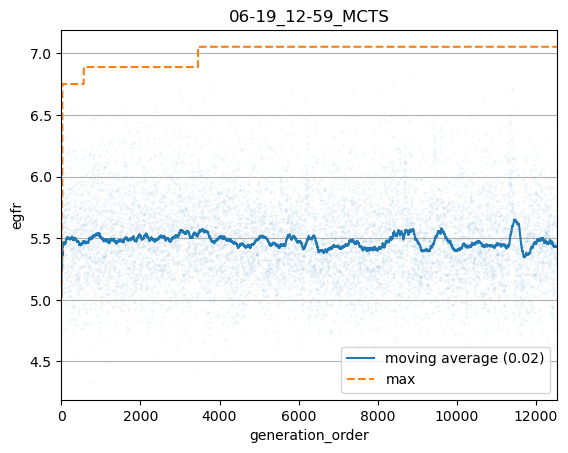

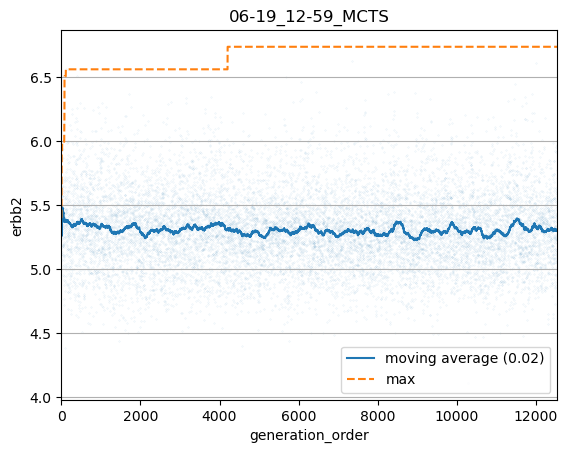

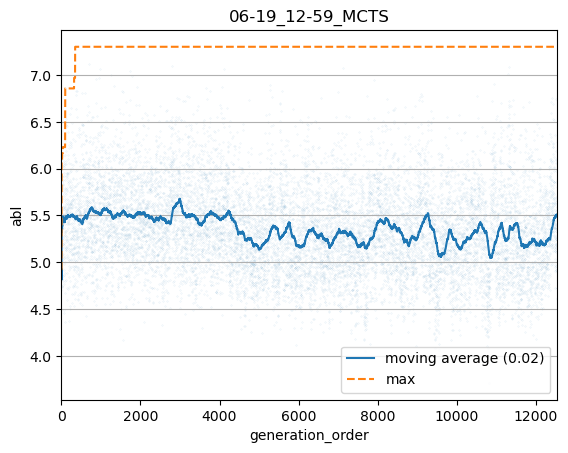

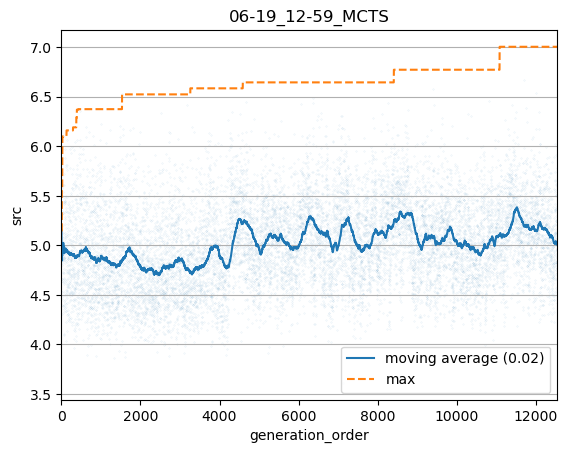

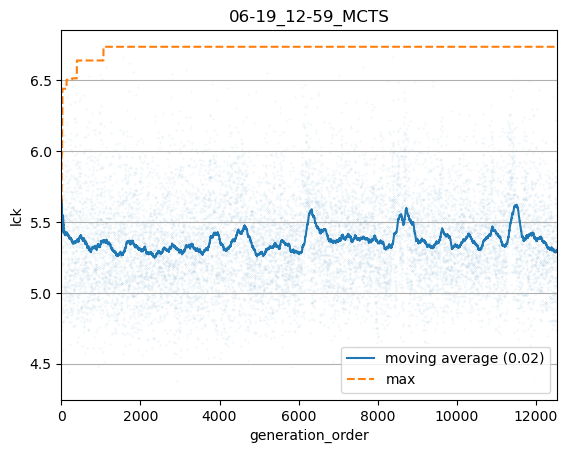

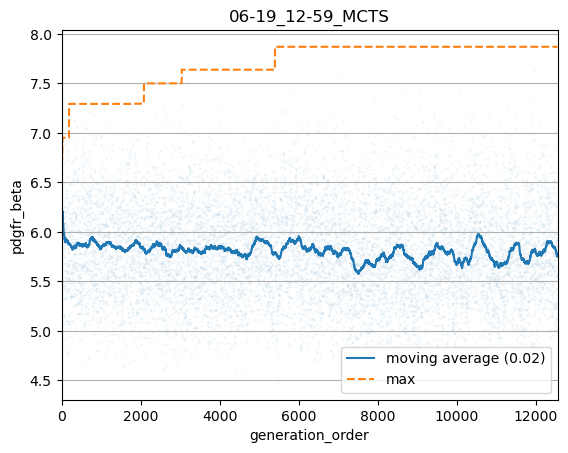

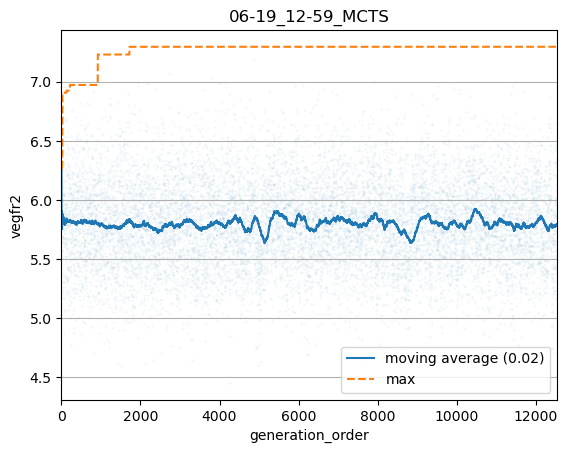

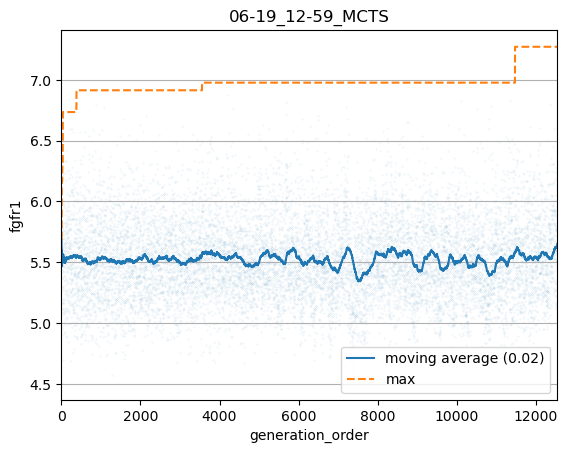

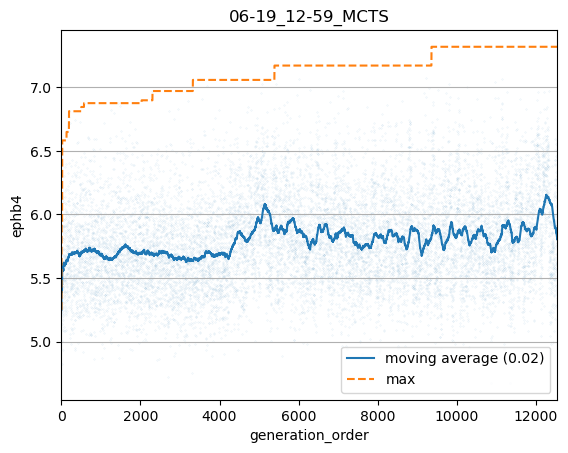

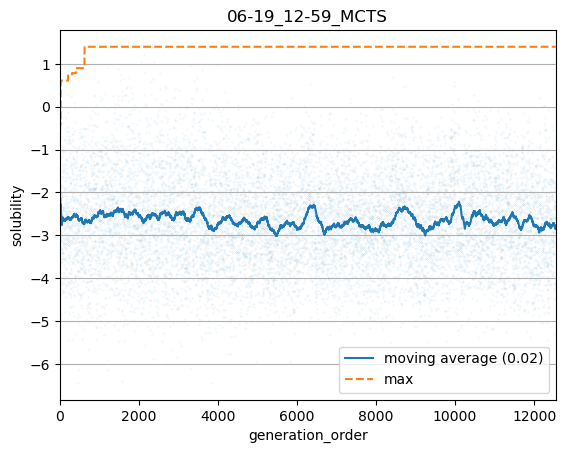

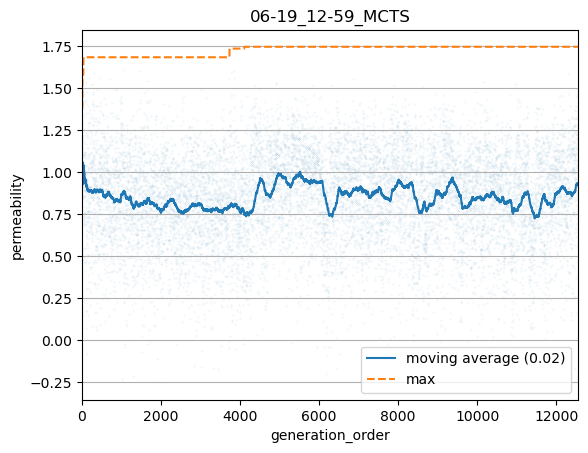

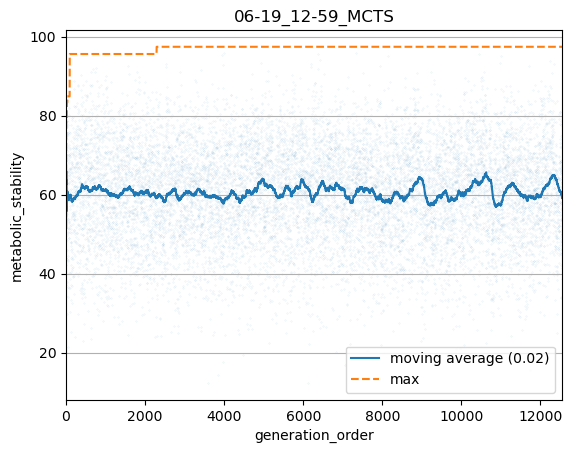

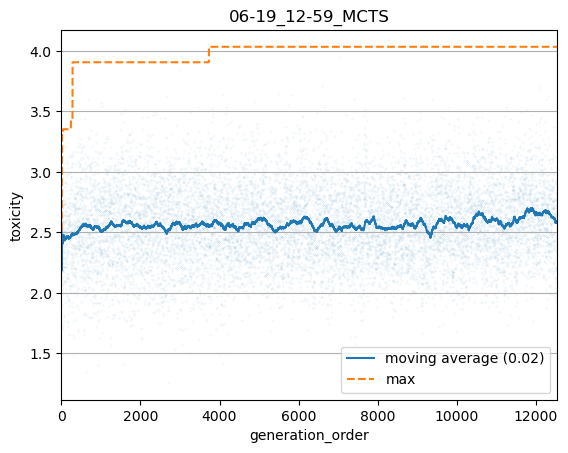

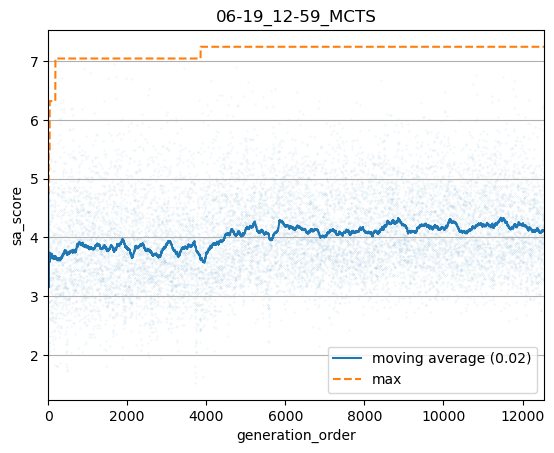

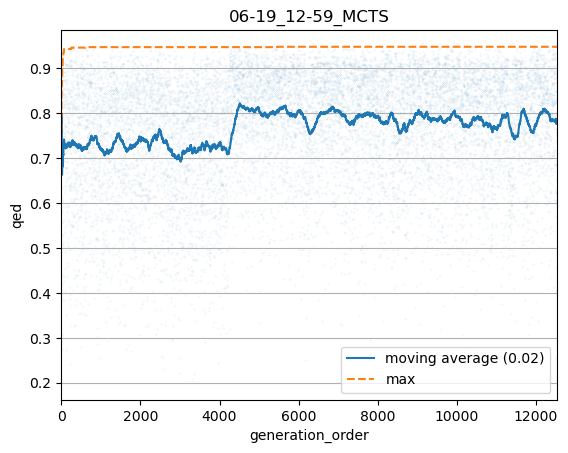

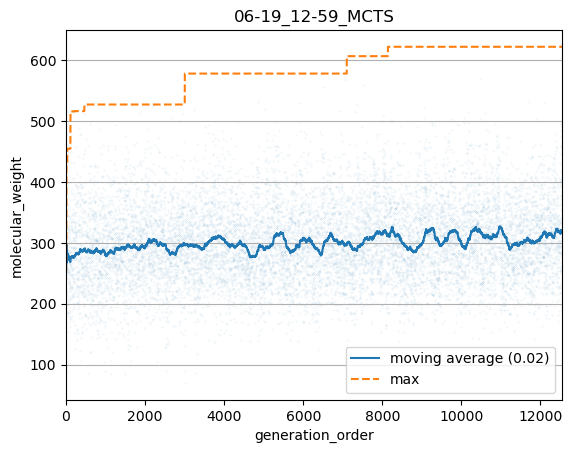

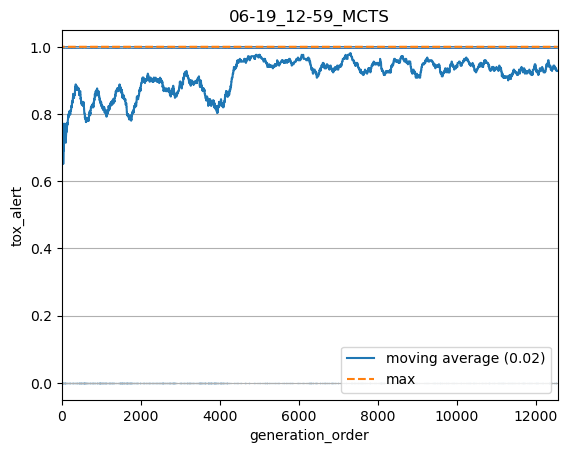

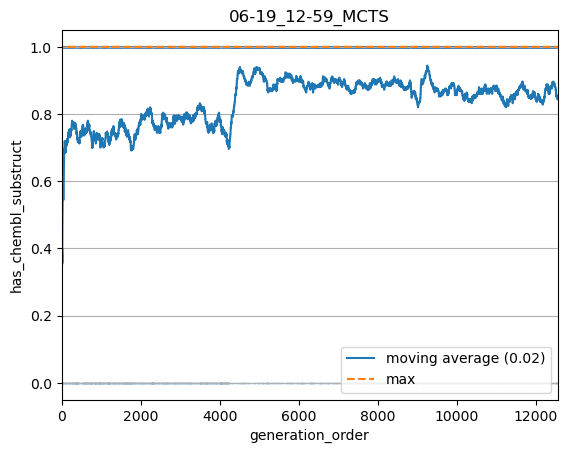

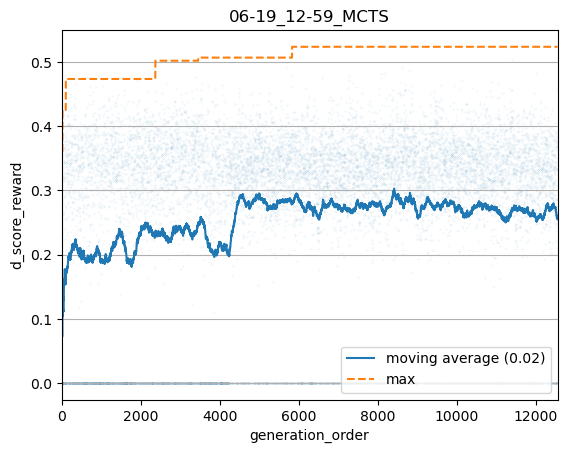

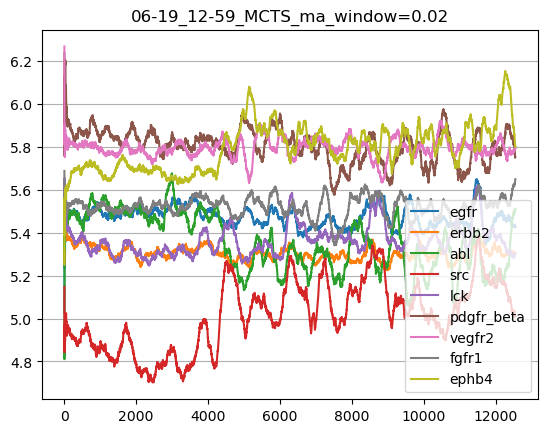

number of generated nodes: 12546
valid rate: 0.623773173391494
unique rate: 0.9981659561812234
node_per_sec: 24.411174703723884


In [12]:
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
c3 = "config/mcts_smiles.yaml"
c4 = "config/model_test.yaml"
c5 = "config/mcts_d_score_diversion.yaml"
generator, conf = read_yaml(c5)
generate_and_analyze(generator, conf)
# queue_yaml(c1, c2)

In [ ]:
#continue search
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

Starting generation...
generated: 12600, time: 515.37, average over 100: 0.2392
generated: 12700, time: 518.23, average over 100: 0.2733
generated: 12800, time: 521.17, average over 100: 0.2565
generated: 12900, time: 524.47, average over 100: 0.2623


In [4]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts test
load_path = generator.output_dir() + "save.mcts"
generator = MCTS.load(load_path, generator.transition) #TODO: separate notebook

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
read_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)